In [5]:
import os
import glob
import torch
import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline
from sklearn.metrics import classification_report

#!pip install transformers
import pandas as pd
from sklearn.model_selection import train_test_split
import torch

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer, AutoModel, TFAutoModel
from transformers.models.auto.modeling_auto import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModel

from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np

from transformers import Trainer, TrainingArguments
from torch import nn

from typing import Tuple
from sklearn.metrics import classification_report

import torch
from sklearn.model_selection import train_test_split

import glob

import seaborn as sns
import matplotlib.pyplot as plt

# specify the directory path
#dir_path = '../../../data/volume_2/publicsphere-new/'  # replace with the path to your folder
dir_path = '../data/volume_2/publicsphere-data/publicsphere-new/'
DATAPATH = 'data/'
# use glob to get the list of folders

In [45]:
test_variables = ['INTERACTIVITY_DUMMY', 'INCIVILITY_DUMMY', 'HATELIST_FOCUSED_DUMMY', 'RATIONALITY_DUMMY', 'HAS_OPINION_DUMMY', 'LIBERAL_DUMMY', 'CONSERVATIVE_DUMMY']

train_set = pd.read_csv(f'{DATAPATH}train.csv')[test_variables+['ID']+['commentText']]  
test_set = pd.read_csv(f'{DATAPATH}test.csv')[test_variables+['ID']+['commentText']]  

class My_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)
    
def create_datasets(concept, train_set, test_set, tokenizer, max_length=512, test_size=.2, random_state=42):
    
    train_labels = train_set[concept]
    test_labels =  test_set[concept]
    train_texts = train_set['commentText'] 
    test_texts =  test_set['commentText']
    
    train_texts, val_texts, train_labels, val_labels = train_test_split(list(train_texts), list(train_labels), test_size=test_size, random_state=random_state)

    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length)
    test_encodings  = tokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length)

    train_dataset = My_Dataset(train_encodings, train_labels)
    val_dataset = My_Dataset(val_encodings, val_labels)
    test_dataset = My_Dataset(test_encodings, test_labels)

    return train_dataset, val_dataset, test_dataset, train_texts, val_texts, test_texts, train_labels, val_labels, test_labels



def get_class_report(CONCEPT):
    
    print(f"this is the current concept: {CONCEPT}")
    
    search_string = f"*{CONCEPT}*"  # the part of the filename you want to match
    file = glob.glob(f'{dir_path}{search_string}')[0]

    train_dataset, val_dataset, test_dataset, train_texts, val_texts, test_texts, train_labels, val_labels, test_labels = create_datasets(CONCEPT, train_set, test_set, tokenizer, max_length=512, test_size=.2, random_state=42)
    model = AutoModelForSequenceClassification.from_pretrained(f'{file}', num_labels=2)
    
    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True, device=0)
    predicted_test_scores = pipe(list(test_texts), truncation=True)
    predicted_test_labels = [int(max(prediction, key=lambda x: x['score'])['label'].split('_')[-1]) for prediction in predicted_test_scores]

    print(classification_report(test_labels, predicted_test_labels))    

    df = pd.DataFrame({'commentText': test_set['commentText'], 'ID': test_set['ID'], 'Text': test_texts, 'Predicted_Label': predicted_test_labels, 'True_Label': test_labels})
    return classification_report(test_labels, predicted_test_labels, output_dict=True), df

measure_variables = ['INTERACTIVITY_DUMMY_TRANSFORM', 'INCIVILITY_DUMMY_TRANSFORM', 'HATELIST_FOCUSED_DUMMY_TRANSFORM', 'RATIONALITY_DUMMY_TRANSFORM', 'HAS_OPINION_DUMMY_TRANSFORM', 'LIBERAL_DUMMY_TRANSFORM', 'CONSERVATIVE_DUMMY_TRANSFORM']

model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
    
results = pd.read_csv('outputs/evaluation/PRF1_test.csv')
test_dimensions = set(zip(results.Dimension, results.Label))

performance = []

classif = ['0', '1', 'macro avg', 'weighted avg']

all_test_dfs = []

for label in test_dimensions:
    print(label[1], label[0])
    
    classfication, test_df = get_class_report(label[1])
    test_df[label[1]] = test_df['Predicted_Label']

    
    for c in classif:
        performance.append({'Dimension': label[0], 'Label':label[1], 'Measures': f'{label[1]}_TRANSFORM', 'Class':c,'Precision':classfication[c]['precision'],
                                            'Recall':classfication[c]['recall'],'F1-score':classfication[c]['f1-score'],'support':classfication[c]['support'],'Accuracy_overall':classfication['accuracy']}) 
    all_test_dfs.append(test_df[['commentText', 'ID', 'Text', label[1]]])
    
performance_df = pd.DataFrame(performance)
final_test_df = pd.concat(all_test_dfs, ignore_index=True)

HATELIST_FOCUSED_DUMMY Incivility
this is the current concept: HATELIST_FOCUSED_DUMMY
../data/volume_2/publicsphere-data/publicsphere-new/best_f1_model_HATELIST_FOCUSED_DUMMY_10_3e-05_0


/home/akroon/.local/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.92      0.85      0.88       613
           1       0.56      0.71      0.62       160

    accuracy                           0.82       773
   macro avg       0.74      0.78      0.75       773
weighted avg       0.84      0.82      0.83       773

INCIVILITY_DUMMY Incivility
this is the current concept: INCIVILITY_DUMMY
../data/volume_2/publicsphere-data/publicsphere-new/best_f1_model_INCIVILITY_DUMMY_10_3e-06_0


/home/akroon/.local/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.74      0.75      0.75       408
           1       0.72      0.70      0.71       365

    accuracy                           0.73       773
   macro avg       0.73      0.73      0.73       773
weighted avg       0.73      0.73      0.73       773

CONSERVATIVE_DUMMY Diversity
this is the current concept: CONSERVATIVE_DUMMY
../data/volume_2/publicsphere-data/publicsphere-new/best_f1_model_CONSERVATIVE_DUMMY_10_3e-06_100


/home/akroon/.local/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.89      0.85      0.87       660
           1       0.31      0.41      0.35       113

    accuracy                           0.78       773
   macro avg       0.60      0.63      0.61       773
weighted avg       0.81      0.78      0.79       773

RATIONALITY_DUMMY Rationality
this is the current concept: RATIONALITY_DUMMY
../data/volume_2/publicsphere-data/publicsphere-new/best_f1_model_RATIONALITY_DUMMY_10_3e-06_0


/home/akroon/.local/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.89      0.88      0.89       624
           1       0.54      0.56      0.55       149

    accuracy                           0.82       773
   macro avg       0.72      0.72      0.72       773
weighted avg       0.83      0.82      0.82       773

HAS_OPINION_DUMMY Diversity
this is the current concept: HAS_OPINION_DUMMY
../data/volume_2/publicsphere-data/publicsphere-new/best_f1_model_HAS_OPINION_DUMMY_10_3e-07_100


/home/akroon/.local/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.24      0.37       402
           1       0.53      0.94      0.68       371

    accuracy                           0.57       773
   macro avg       0.67      0.59      0.52       773
weighted avg       0.68      0.57      0.52       773

INTERACTIVITY_DUMMY Interactivity
this is the current concept: INTERACTIVITY_DUMMY
../data/volume_2/publicsphere-data/publicsphere-new/best_f1_model_INTERACTIVITY_DUMMY_10_3e-06_0


/home/akroon/.local/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.87      0.84      0.86       559
           1       0.62      0.68      0.65       214

    accuracy                           0.79       773
   macro avg       0.74      0.76      0.75       773
weighted avg       0.80      0.79      0.80       773

LIBERAL_DUMMY Diversity
this is the current concept: LIBERAL_DUMMY
../data/volume_2/publicsphere-data/publicsphere-new/best_f1_model_LIBERAL_DUMMY_10_3e-06_0


/home/akroon/.local/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.92      0.59      0.72       633
           1       0.30      0.78      0.43       140

    accuracy                           0.62       773
   macro avg       0.61      0.68      0.57       773
weighted avg       0.81      0.62      0.67       773



In [49]:
# create one .csv file with all results

final_test_df = all_test_dfs[0]
for df in all_test_dfs[1:]:
    final_test_df = pd.merge(final_test_df, df, on=['commentText', 'ID', 'Text'], how='outer')
final_test_df.drop('Text', axis=1, inplace=True)

new_column_names = {
    'HATELIST_FOCUSED_DUMMY': 'HATELIST_FOCUSED_DUMMY_FT',
    'INCIVILITY_DUMMY': 'INCIVILITY_DUMMY_FT',
    'CONSERVATIVE_DUMMY': 'CONSERVATIVE_DUMMY_FT',
    'RATIONALITY_DUMMY': 'RATIONALITY_DUMMY_FT',
    'HAS_OPINION_DUMMY': 'HAS_OPINION_DUMMY_FT',
    'INTERACTIVITY_DUMMY': 'INTERACTIVITY_DUMMY_FT',
    'LIBERAL_DUMMY': 'LIBERAL_DUMMY_FT'
}

final_test_df.rename(columns=new_column_names, inplace=True)

In [70]:
final_test_df.head(3)

,commentText,ID,HATELIST_FOCUSED_DUMMY_FT,INCIVILITY_DUMMY_FT,CONSERVATIVE_DUMMY_FT,RATIONALITY_DUMMY_FT,HAS_OPINION_DUMMY_FT,INTERACTIVITY_DUMMY_FT,LIBERAL_DUMMY_FT
0,That's a vicious insult!!! What did a box of r...,Ugx2WXq9UdV8mPPjejJ4AaABAg.8yHCKV0Boe58yYRxEQEF45,1,1,0,0,1,1,0
1,Goya Solidar. So there are a few of us left. ...,UgwUPFScjJ0MCeaP2F54AaABAg.8lvp3fc9Euf8lvvgsUgEgV,0,0,0,0,1,1,1
2,Trump is a Traitor! Lock that coward up!,UgwRZv_F4VDm_-Z-f6l4AaABAg,1,1,1,0,1,0,1


In [68]:
final_test_df.to_csv('outputs/automated_results/prediction_FT.csv')

In [67]:
performance_df.to_csv('outputs/evaluation/PRF1_test_including_transformers.csv')

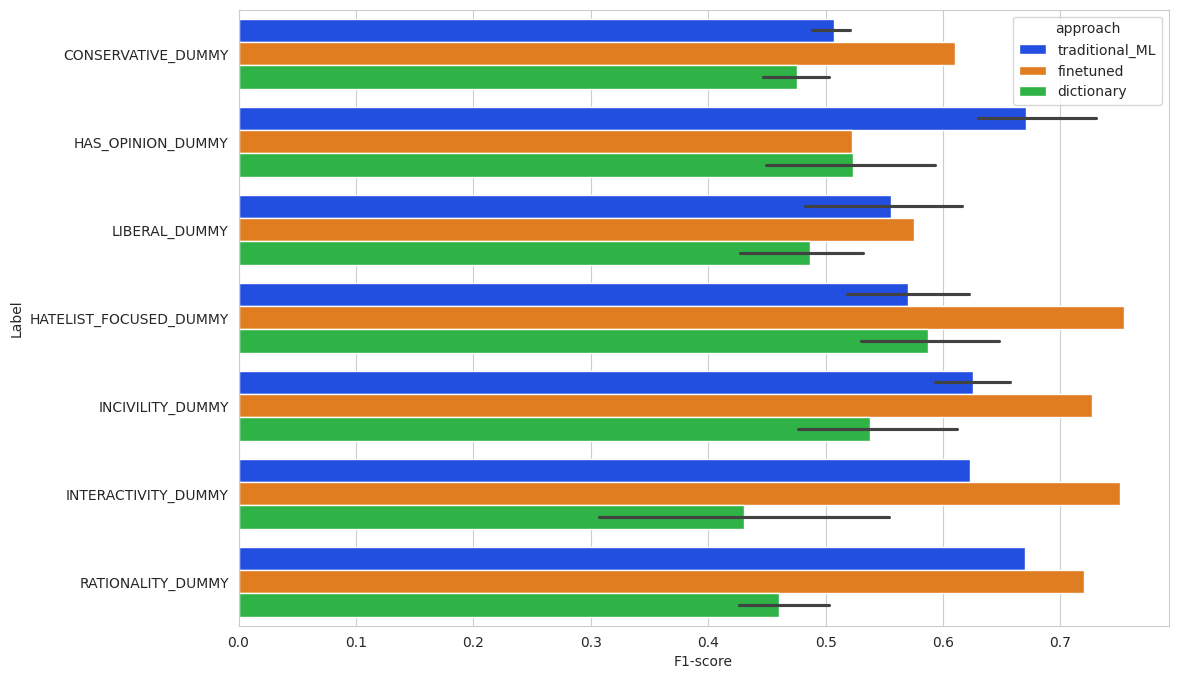

In [71]:
# Concatenate the DataFrames
f_results = pd.concat([results, performance_df], ignore_index=True)
f_results.sort_values(by=['Dimension', 'Label', 'Measures'], inplace=True)
f_results['approach'] = f_results['Measures'].apply(lambda x: 'traditional_ML' if x.endswith('_ML') else 'finetuned' if x.endswith('_TRANSFORM') else 'dictionary')
#f_results.to_csv('results_with_transformers.csv')

# create figure and set its size
plt.figure(figsize=(12, 8))
# set plot style
sns.set_style('whitegrid')

# plot bar plot
g = sns.barplot(data=f_results[f_results['Class']=='macro avg'], y='Label', x='F1-score', hue='approach', palette='bright')